In [2]:
from __future__ import division
import torch
from torch.utils import data

import torch.nn.functional as F

# general libs
import numpy as np
import tqdm
import matplotlib.pyplot as plt


### My libs
from machine_perception.experiments.stm.dataset import MoseDataset
from machine_perception.experiments.stm.model import STM, load_stm_state_dict

torch.set_grad_enabled(False)  # Volatile

In [3]:
DATA_ROOT = (
    R"D:\Documents\University\MSc\Sem1\MachinePerception\machine-perception\data"
)
WEIGHTS_PATH = R"D:\Documents\University\MSc\Sem1\MachinePerception\machine-perception\STM_weights.pth"

print(f"{torch.cuda.is_available() = }")

torch.cuda.is_available() = True


In [4]:
def Run_video(Fs, Ms, num_frames, num_objects, Mem_every=None, Mem_number=None):
    # initialize storage tensors
    if Mem_every:
        to_memorize = [int(i) for i in np.arange(0, num_frames, step=Mem_every)]
    elif Mem_number:
        to_memorize = [
            int(round(i)) for i in np.linspace(0, num_frames, num=Mem_number + 2)[:-1]
        ]
    else:
        raise NotImplementedError

    Es = torch.zeros_like(Ms)
    Es[:, :, 0] = Ms[:, :, 0]

    for t in tqdm.tqdm(range(1, num_frames)):
        # memorize
        with torch.no_grad():
            num_objects_t = torch.tensor([num_objects])
            if torch.cuda.is_available():
                Fs = Fs.cuda()
                Es = Es.cuda()
                num_objects_t = num_objects_t.cuda()
            prev_key, prev_value = model(
                Fs[:, :, t - 1], Es[:, :, t - 1], num_objects_t
            )

        if t - 1 == 0:  #
            this_keys, this_values = prev_key, prev_value  # only prev memory
        else:
            this_keys = torch.cat([keys, prev_key], dim=3)
            this_values = torch.cat([values, prev_value], dim=3)

        # segment
        with torch.no_grad():
            num_objects_t = torch.tensor([num_objects])
            if torch.cuda.is_available():
                Fs = Fs.cuda()
                this_keys = this_keys.cuda()
                this_values = this_values.cuda()
                num_objects_t = num_objects_t.cuda()
            logit = model(Fs[:, :, t], this_keys, this_values, num_objects_t)
        Es[:, :, t] = F.softmax(logit, dim=1)

        # update
        if t - 1 in to_memorize:
            keys, values = this_keys, this_values

    pred = np.argmax(Es[0].cpu().numpy(), axis=0).astype(np.uint8)
    return pred, Es

In [5]:
dataset_test = MoseDataset(
    DATA_ROOT,
    imset="meta_test_split.json",
    single_object=False,
)
dataloader_test = data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

In [6]:
model = STM()
if torch.cuda.is_available():
    model.cuda()
model.eval()  # turn-off BN

print("Loading weights:", WEIGHTS_PATH)
model.load_state_dict(load_stm_state_dict(WEIGHTS_PATH))

d:\mamba\envs\machineperc\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\mamba\envs\machineperc\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading weights: D:\Documents\University\MSc\Sem1\MachinePerception\machine-perception\STM_weights.pth


<All keys matched successfully>

In [7]:
# for seq, V in enumerate(dataloader_test):
#     Fs, Ms, num_objects, info = V
#     seq_name = info["name"][0]
#     num_frames = info["num_frames"][0].item()
#     print(
#         "[{}]: num_frames: {}, num_objects: {}".format(
#             seq_name, num_frames, num_objects[0][0]
#         )
#     )

#     pred, Es = Run_video(Fs, Ms, num_frames, num_objects, Mem_every=5, Mem_number=None)
#     pass

# Save results for quantitative eval ######################
# test_path = os.path.join("./test", code_name, seq_name)
# if not os.path.exists(test_path):
#     os.makedirs(test_path)
# for f in range(num_frames):
#     img_E = Image.fromarray(pred[f])
#     img_E.putpalette(PALETTE)
#     img_E.save(os.path.join(test_path, "{:05d}.png".format(f)))

In [8]:
idx = 10
Fs, Ms, num_objects, info = dataset_test[idx]
Fs = Fs.unsqueeze(dim=0)
Ms = Ms.unsqueeze(dim=0)
seq_name = info["name"]
num_frames = info["num_frames"]
pred, Es = Run_video(Fs, Ms, num_frames, num_objects, Mem_every=5, Mem_number=None)

  2%|▏         | 1/42 [01:57<1:20:24, 117.68s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.49 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 7.52 GiB is allocated by PyTorch, and 410.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def show_preds(Fs: torch.Tensor, pred: np.ndarray):
    frames_np = Fs.cpu().numpy()[0].transpose(1, 2, 3, 0)
    n_frames = frames_np.shape[0]

    fig, axs = plt.subplots(n_frames, 1, figsize=(10, 4 * n_frames))

    for i in range(n_frames):
        axs[i].imshow(frames_np[i])
        axs[i].imshow(pred[i], alpha=0.5)

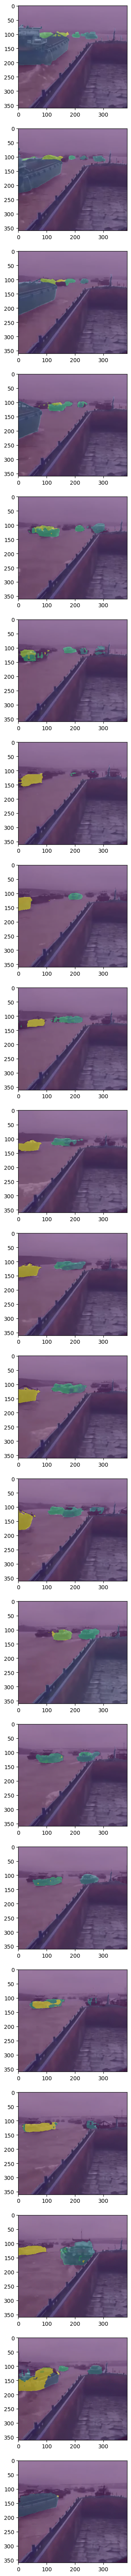

In [13]:
show_preds(Fs, pred)

In [ ]:
Fs.shape

torch.Size([1, 3, 8, 1080, 1920])

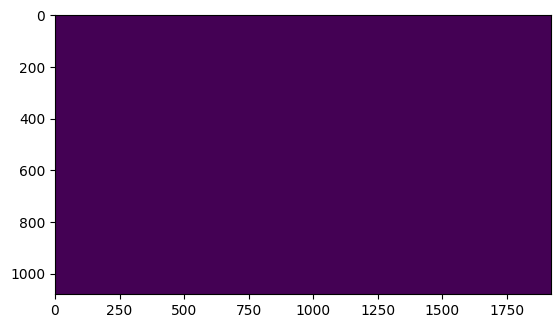

In [ ]:
plt.imshow(pred[2])